In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
from glob import glob
import cv2

from GDN_Jorge import GDN as GDNJ

In [3]:
path = '/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013'

In [4]:
len(glob(os.path.join(path, 'distorted_images', '*.bmp')))

3000

In [5]:
len(glob(os.path.join(path, 'reference_images', '*.BMP')))

25

We load the filename-metric pairs:

In [6]:
name_metric = {}
with open(os.path.join(path, 'mos_with_names.txt')) as f:
    for line in f.readlines():
        # remove last character to avoid \n
        metric, file_name = line[:-1].split(" ")
        name_metric[file_name.lower().split(".")[0]] = float(metric)

Fetch the image names with glob and turn all of them to lowercase:

In [7]:
from collections import namedtuple

We create a `namedtuple` to make the code cleaner:

In [8]:
ImagePair = namedtuple('ImagePair', 'img_path dist_img_path metric')

In [9]:
data = []
for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
    # img_path = img_path.lower()
    for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
        data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    #     break
    # break

We can easily turn this list into a generator that loads each image only when is needed:

In [10]:
def test_gen():
    for sample in data:
        img = cv2.imread(sample.img_path)
        dist_img = cv2.imread(sample.dist_img_path)
        metric = sample.metric
        yield img, dist_img, metric

In [11]:
a_shapes, b_shapes = [], []
for a, b, c in test_gen():
    a_shapes.append(a.shape)
    b_shapes.append(b.shape)
    break

We can check that all the images have the same shape:

In [12]:
from collections import Counter

In [13]:
Counter(a_shapes)

Counter({(384, 512, 3): 1})

In [14]:
Counter(b_shapes)

Counter({(384, 512, 3): 1})

And we can plot a pair to see them:

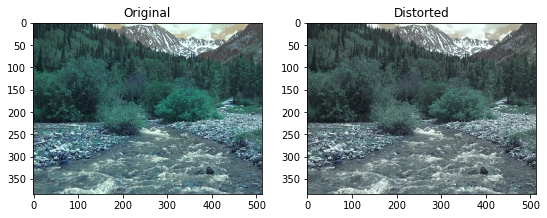

In [15]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(a)
plt.subplot(1,2,2)
plt.title("Distorted")
plt.imshow(b)
plt.show()

And finally, we turn this generator into a `tf.data.Dataset`:

In [16]:
a.shape

(384, 512, 3)

In [17]:
dataset = tf.data.Dataset.from_generator(test_gen,
                                         output_signature=(
                                             tf.TensorSpec(shape=(384, 512, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(384, 512, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(), dtype=tf.float32)
                                         ))

2022-03-01 15:37:53.234159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10465 MB memory:  -> device: 0, name: Tesla K40m, pci bus id: 0000:03:00.0, compute capability: 3.5


In [18]:
for a, b, c in dataset:
    break

2022-03-01 15:37:53.556089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Define loss function

PerceptNet is trained to maximize the Pearson correlation coefficient between the MOS and the L2 distance of the two images in the transformed domain, so we'll now define a custom loss function inhereting from `tf.keras.losses.Loss`:

In [19]:
class PearsonCorrelation(tf.keras.losses.Loss):
    """
    Loss used to train PerceptNet. Is calculated as the 
    Pearson Correlation Coefficient for a sample.
    """

    def call(self, y_true, y_pred):
        num = (y_true-tf.reduce_mean(y_true, axis=0))
        num *= (y_true-tf.reduce_mean(y_pred, axis=0))
        num = tf.reduce_sum(num)
        denom = tf.sqrt(tf.reduce_sum((y_true-tf.reduce_mean(y_true,axis=0))**2))
        denom *= tf.sqrt(tf.reduce_sum((y_pred-tf.reduce_mean(y_pred,axis=0))**2))
        return num/denom

## Define PerceptNet

We might need to define PerceptNet as an inhereted model to be able to manage the `train_step` properly:

In [50]:
class PerceptNet(tf.keras.Model):
    def __init__(self):
        super(PerceptNet, self).__init__()
        self.model = tf.keras.Sequential([
            GDNJ(kernel_size=1, apply_independently=True),
            layers.Conv2D(filters=3, kernel_size=1, strides=1, padding='same'),
            layers.MaxPool2D(2),
            GDNJ(kernel_size=1),
            layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same'),
            layers.MaxPool2D(2),
            GDNJ(kernel_size=1),
            layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='same'),
            GDNJ(kernel_size=1)
        ])
    
    def call(self, X):
        return self.model(X)

    def train_step(self, data):
        """
        X: tuple (Original Image, Distorted Image)
        Y: float (MOS score)
        """
        # print(data)

        img, dist_img, mos = data
        # img, dist_img = img
        # print(img)
        # print(dist_img)
        # print(mos)
        # print(img.shape, dist_img.shape, mos.shape)
        with tf.GradientTape() as tape:
            features_original = self(img)
            features_distorted = self(dist_img)
            # print(features_original.shape, features_distorted.shape)
            features_original = layers.Flatten()(features_original)
            features_distorted = layers.Flatten()(features_distorted)
            # print(features_original.shape, features_distorted.shape)
            l2 = tf.sqrt(tf.reduce_sum((features_original-features_distorted)**2, axis=-1))
            loss = -self.compiled_loss(mos, l2)
            loss = tf.reduce_mean(loss)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'pearson':loss}


In [51]:
model = PerceptNet()
model.compile(optimizer='adam',
              loss=PearsonCorrelation())

In [52]:
model.fit(dataset.batch(32))

     35/Unknown - 33s 848ms/step - pearson: -0.2837